In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout, Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.data import AUTOTUNE, Dataset
# from tensorflow.data.Dataset import from_tensor_slices
from tensorflow import cast, float32, expand_dims, TensorSpec
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [37]:
train_path="data/train"
test_path="data/test"
val_path="data/valid"

In [38]:
print("Train Data")

x_train=[]
for folder in os.listdir(train_path):
  sub_path=train_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path=sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224,224))
    x_train.append(img_arr)

print("Test Data")

x_test=[]
for folder in os.listdir(test_path):
  sub_path=test_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path=sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224,224))
    x_test.append(img_arr)
    
print("Validation Data")
    
x_val=[]
for folder in os.listdir(val_path):
  sub_path=val_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path = sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224,224))
    x_val.append(img_arr)

Train Data
Test Data
Validation Data


In [39]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [40]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
 target_size = (224, 224),
 batch_size = 32,
 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
 target_size = (224, 224),
 batch_size = 32,
 class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
 target_size = (224, 224),
 batch_size = 32,
 class_mode = 'sparse')

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [41]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

1.0


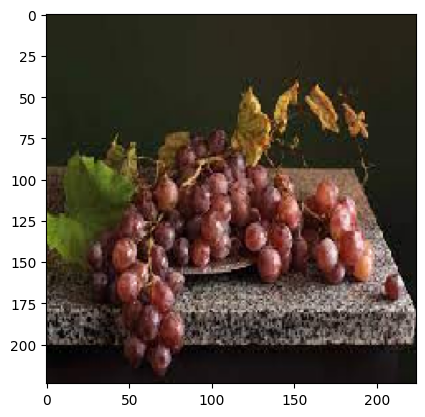

In [42]:
image, label = next(iter(training_set))
print(np.max(image[0]))
plt.imshow(image[0])

(224, 224, 3)
Min and max pixel values: 0.0 1.0


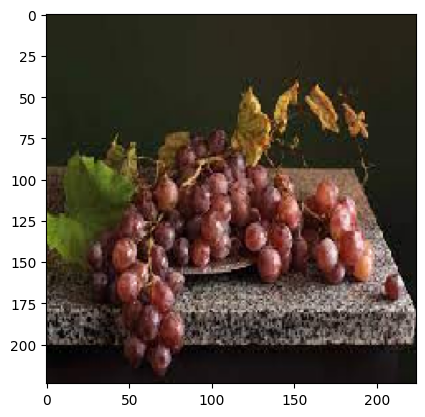

In [43]:
resize_and_rescale = Sequential([
  Resizing(224, 224),
])

result = resize_and_rescale(image[0])
print(result.shape)

plt.imshow(result)

print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

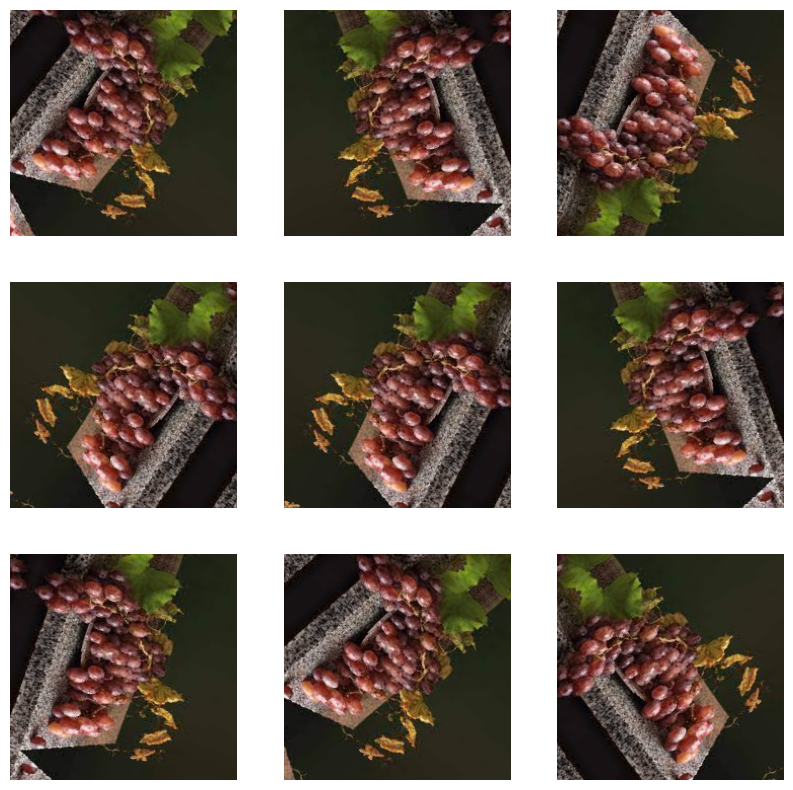

In [44]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

image = cast(expand_dims(result, 0), float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


In [45]:
batch_size = 32
AUTOTUNE = AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  ds
  print(next(iter(ds)))
  # Resize and rescale all datasets.
  # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda x: resize_and_rescale(x))
  print(next(iter(ds)))

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  # if augment:
    # ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
    #             num_parallel_calls=AUTOTUNE)

    # ds = data_augmentation(next(iter(ds)), training=True)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [49]:
train_x = Dataset.from_tensor_slices(train_x)

MemoryError: Unable to allocate 10.9 GiB for an array with shape (9700, 224, 224, 3) and data type float64

In [35]:
out = prepare(train_x, shuffle=True, augment=True)
val_x = prepare(val_x)
test_x = prepare(test_x)

tf.Tensor(
[[[1.         0.98431373 0.98039216]
  [1.         0.98431373 0.98039216]
  [1.         0.98431373 0.98039216]
  ...
  [1.         0.99607843 0.99215686]
  [1.         0.99607843 0.99215686]
  [1.         0.99607843 0.99215686]]

 [[1.         0.98431373 0.98039216]
  [1.         0.98431373 0.98039216]
  [1.         0.98431373 0.98039216]
  ...
  [1.         0.99607843 0.99215686]
  [1.         0.99607843 0.99215686]
  [1.         0.99607843 0.99215686]]

 [[1.         0.98431373 0.98039216]
  [1.         0.98431373 0.98039216]
  [1.         0.98431373 0.98039216]
  ...
  [1.         0.99607843 0.99215686]
  [1.         0.99607843 0.99215686]
  [1.         0.99607843 0.99215686]]

 ...

 [[0.98823529 0.96862745 0.96470588]
  [0.98823529 0.96862745 0.96470588]
  [0.98823529 0.96862745 0.96470588]
  ...
  [0.99607843 0.98823529 0.98431373]
  [0.99607843 0.98823529 0.98431373]
  [0.99607843 0.98823529 0.98431373]]

 [[0.98823529 0.96862745 0.96470588]
  [0.98823529 0.96862745 0

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [89]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((9700,), (100,), (200,))

In [90]:
vgg = VGG19(input_shape=[224,224] + [3], weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
  layer.trainable = False

In [128]:
x = Flatten()(vgg.output)
# Vi tilføjer en output layer med en Softmax classifier da det er en
# multi-class klassifikationsmodel vi bygger.
prediction = Dense(5, activation='softmax')(x)
realmodel = Model(inputs=vgg.input, outputs=prediction)

print(realmodel.summary())

model = Sequential([
  resize_and_rescale,
  data_augmentation,
  realmodel
])

# model = Sequential([
#   # Add the preprocessing layers you created earlier.
#   resize_and_rescale,
#   data_augmentation,
#   Conv2D(16, 3, padding='same', activation='relu'),
#   MaxPooling2D(),
#   realmodel
# ])

#For at få et overblik over modellen kan vi:
model.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │       125,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,149,829 (76.87 MB)

 Trainable params: 125,445 (490.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

None


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_45 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_46 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_52 (Functional)      │ ?                      │    20,149,829 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,149,829 (76.87 MB)

 Trainable params: 125,445 (490.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [125]:
model.compile(
loss='sparse_categorical_crossentropy',
optimizer="adam",
metrics=['accuracy']
)

In [126]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [127]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=1,
  callbacks=[early_stop],
  batch_size=64,shuffle=True)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_47" is incompatible with the layer: expected shape=(None, 224, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_157>',)
  • kwargs={'mask': 'None'}

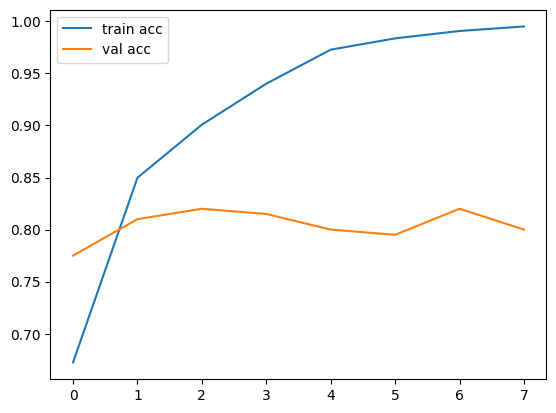

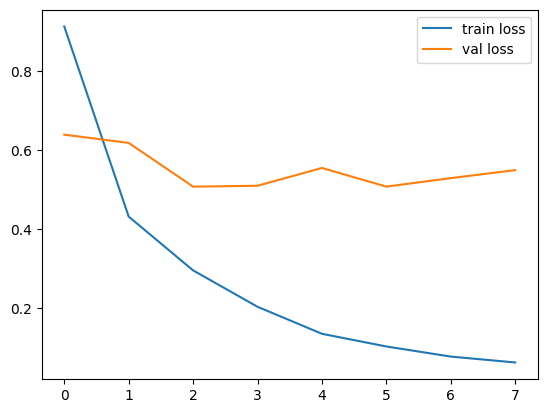

In [15]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [13]:
model.save("model.keras")


In [18]:
from tensorflow.keras.models import load_model

model = load_model("model.keras")

ValueError: File format not supported: filepath=model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [14]:
model.evaluate(test_x,test_y,batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8693 - loss: 0.3628


[0.4319492280483246, 0.8399999737739563]

In [17]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,test_y))
#get confusion matrix
print(confusion_matrix(y_pred,test_y))

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       1.00      0.80      0.89        25
           2       0.85      0.77      0.81        22
           3       0.70      0.88      0.78        16
           4       0.80      1.00      0.89        16

    accuracy                           0.84       100
   macro avg       0.84      0.85      0.84       100
weighted avg       0.86      0.84      0.84       100

[[17  0  2  2  0]
 [ 0 20  1  3  1]
 [ 2  0 17  1  2]
 [ 1  0  0 14  1]
 [ 0  0  0  0 16]]


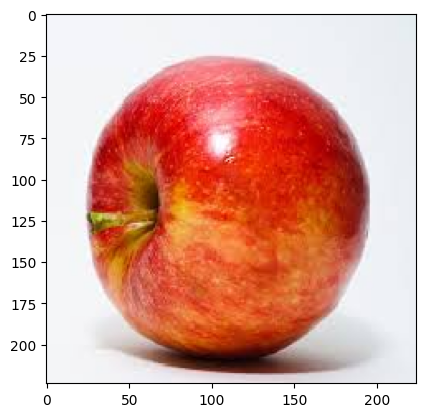

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
[[1.000000e+00 0.000000e+00 4.067616e-15 0.000000e+00 0.000000e+00]]
Apple


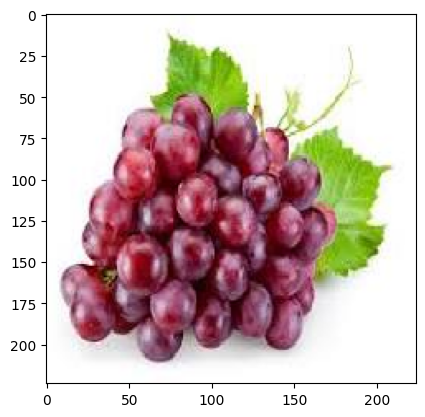

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
[[0. 0. 1. 0. 0.]]
Mango


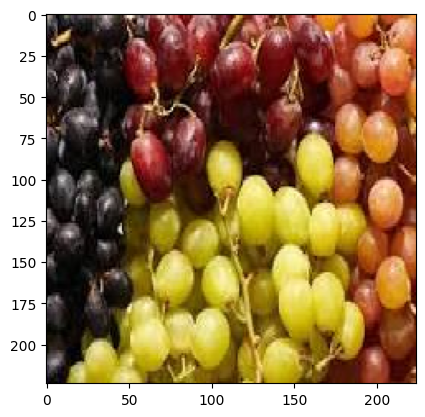

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
[[9.9123073e-01 0.0000000e+00 1.0433994e-16 8.7692877e-03 0.0000000e+00]]
Apple


In [24]:
path="test"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    print(pred)
    if pred[0][0]>0.5:
        print("Apple")
    elif pred[0][1]>0.5:
        print("Strawberry")
    elif pred[0][2]>0.5:
        print("Mango")
    elif pred[0][3]>0.5:
        print('Banana')
    elif pred[0][4]>0.5:
        print('Grape')
    else:
        print("Unknown")